## In this notebook, the data is used to perform several tests

In [1]:
import bt
from scipy.stats import norm
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import datetime
%matplotlib inline
plt.style.use("default")
import warnings
warnings.filterwarnings("ignore")

### Data processed in the previous notebooks is loaded

In [11]:
prices = pd.read_excel("price_index.xlsx",index_col=0)
company_returns = pd.read_excel("company_returns.xlsx",index_col=0)

index_portfolios = pd.read_excel("Simulations.xlsx",index_col=0)
index_portfolios["AVERAGE"] = index_portfolios.mean(axis=1)

returns = index_portfolios.pct_change()

### Below we can see a graph with the evolution of every random portfolio, as well as the average and the S&P 500 index for reference

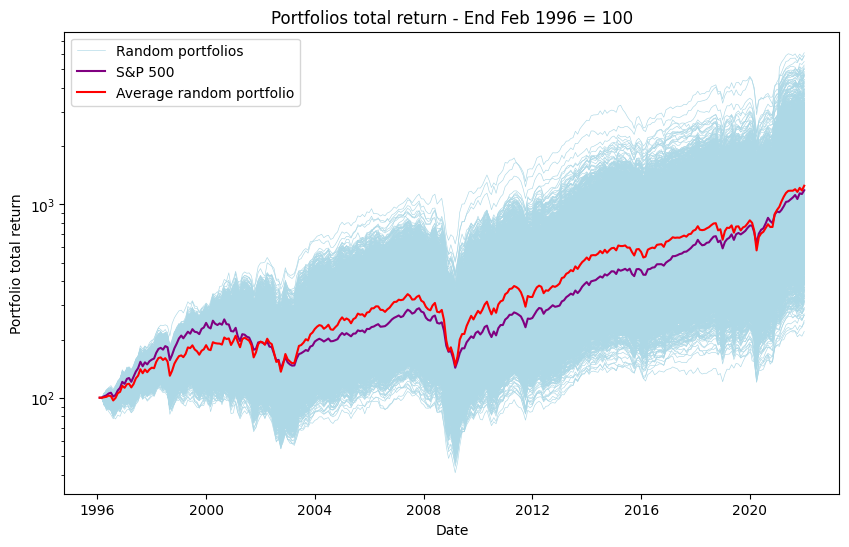

In [13]:
fig,ax1 = plt.subplots(1,figsize=(10,6))
ax1.plot(index_portfolios.iloc[:,0],linewidth=0.45,color="lightblue",label="Random portfolios");
ax1.plot(index_portfolios.iloc[:,1:-2],linewidth=0.45,color="lightblue");
ax1.plot(index_portfolios["SPX"],linewidth=1.5,color="purple",label="S&P 500");
ax1.plot(index_portfolios["AVERAGE"],linewidth=1.5,color="red", label="Average random portfolio");
ax1.set_yscale('log')
ax1.set_title("Portfolios total return - End Feb 1996 = 100");
ax1.legend()

ax1.set_xlabel("Date");
ax1.set_ylabel("Portfolio total return");

plt.savefig("Graphs/Portfolios_total_return.png",dpi=300);

### To divide the period into subperiods, yearly volatility is computed to identify regimes

In [61]:
spxdata = yf.download("SPY",start="1996-03-01",end="2021-12-31",progress=False)["Adj Close"].pct_change().dropna()

spxvol = pd.DataFrame(spxdata.rolling(252).std())
spxyearvol = spxvol.groupby(lambda x: x.year)['Adj Close'].agg(['mean'])

spxyearvol["P1"] = np.nan
spxyearvol["P1"].loc[1998:2003]= spxyearvol.loc[1998:2003].mean().values[0]
spxyearvol["P2"] = np.nan
spxyearvol["P2"].loc[2004:2007]= spxyearvol.loc[2004:2007].mean().values[0]
spxyearvol["P3"] = np.nan
spxyearvol["P3"].loc[2008:2012]= spxyearvol.loc[2008:2012].mean().values[0]
spxyearvol["P4"] = np.nan
spxyearvol["P4"].loc[2013:2017]= spxyearvol.loc[2013:2017].mean().values[0]
spxyearvol["P5"] = np.nan
spxyearvol["P5"].loc[2018:2021]= spxyearvol.loc[2018:2021].mean().values[0]

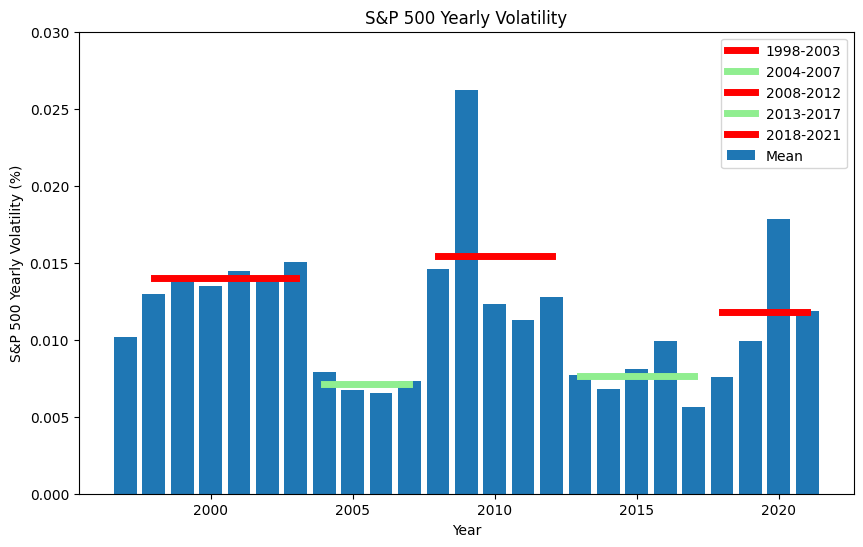

In [62]:
######## plot spx yearly volatility

fig,ax1 = plt.subplots(1,figsize=(10,6))
ax1.bar(list(spxyearvol.index),spxyearvol["mean"].values,label="Mean");
ax1.plot(spxyearvol.index,spxyearvol["P1"].values,label="1998-2003",linewidth=5,color="red");
ax1.plot(spxyearvol.index,spxyearvol["P2"].values,label="2004-2007",linewidth=5,color="lightgreen");
ax1.plot(spxyearvol.index,spxyearvol["P3"].values,label="2008-2012",linewidth=5,color="red");
ax1.plot(spxyearvol.index,spxyearvol["P4"].values,label="2013-2017",linewidth=5,color="lightgreen");
ax1.plot(spxyearvol.index,spxyearvol["P5"].values,label="2018-2021",linewidth=5,color="red");
ax1.set_title("S&P 500 Yearly Volatility");
ax1.legend()

ax1.set_ylim(0,0.03)
ax1.set_xlabel("Year");
ax1.set_ylabel("S&P 500 Yearly Volatility (%)");

plt.savefig("Graphs/S&P_yearly_volatility.png",dpi=300);

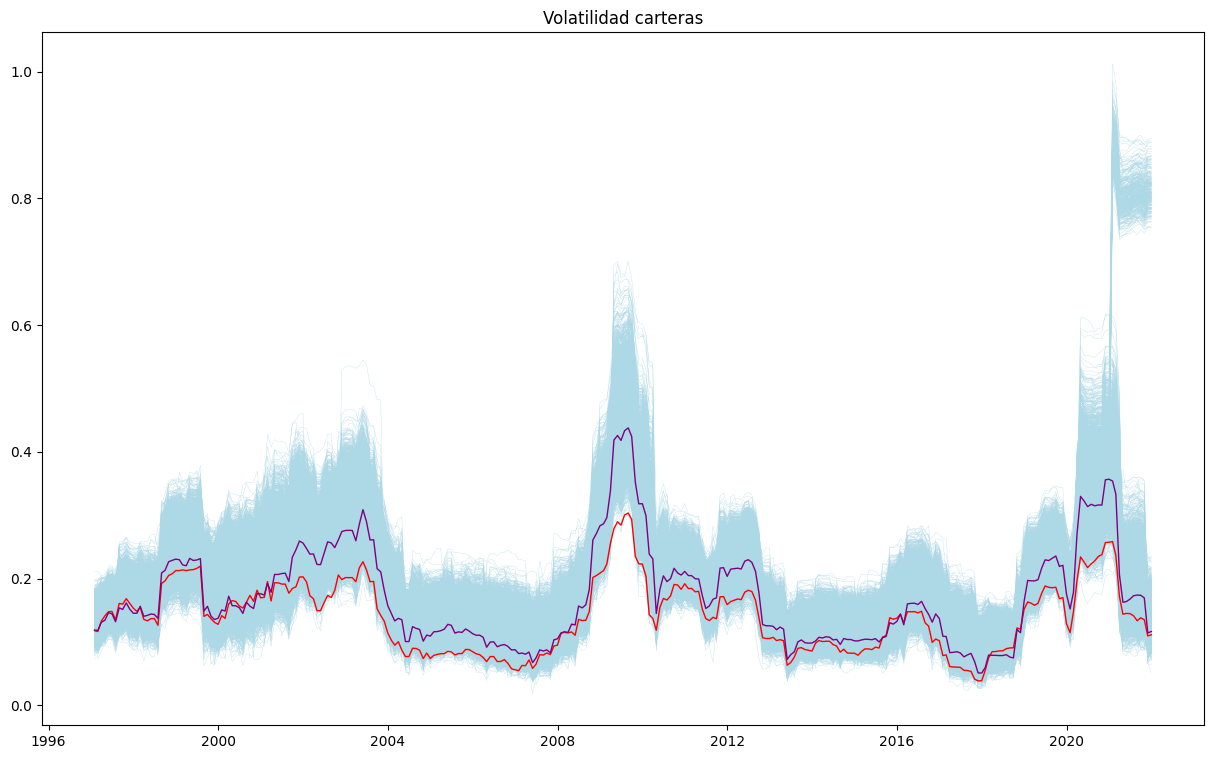

In [16]:
### volatilidades de los portfolios en rolling periods de 12 meses

fig,ax1 = plt.subplots(1,figsize=(15,9))
ax1.plot(((returns.rolling(12).std() * np.sqrt(12)).iloc[:,:-2]),linewidth=0.2,color="lightblue");
ax1.plot(((returns.rolling(12).std() * np.sqrt(12))["SPX"]),linewidth=1,color="red");
ax1.plot(((returns.rolling(12).std() * np.sqrt(12))["AVERAGE"]),linewidth=1,color="purple");
plt.title("Volatilidad carteras");

In [17]:
### calculo métricas portfolios

ann_rets = (index_portfolios.iloc[-1] /  index_portfolios.iloc[0])**(12/(12*26)) - 1 

metrics = pd.DataFrame(ann_rets,columns=["Annual Return"])

metrics["Annual Volatility"] = index_portfolios.pct_change().dropna().std() * np.sqrt(12)

metrics["Return / Volatility"] = metrics["Annual Return"] / metrics["Annual Volatility"]

return_position_spx = metrics["Annual Return"].sort_values(ascending=False).index.get_loc("SPX")

volatility_position_spx = metrics["Annual Volatility"].sort_values(ascending=False).index.get_loc("SPX")

return_vol_position_spx = metrics["Return / Volatility"].sort_values(ascending=False).index.get_loc("SPX")

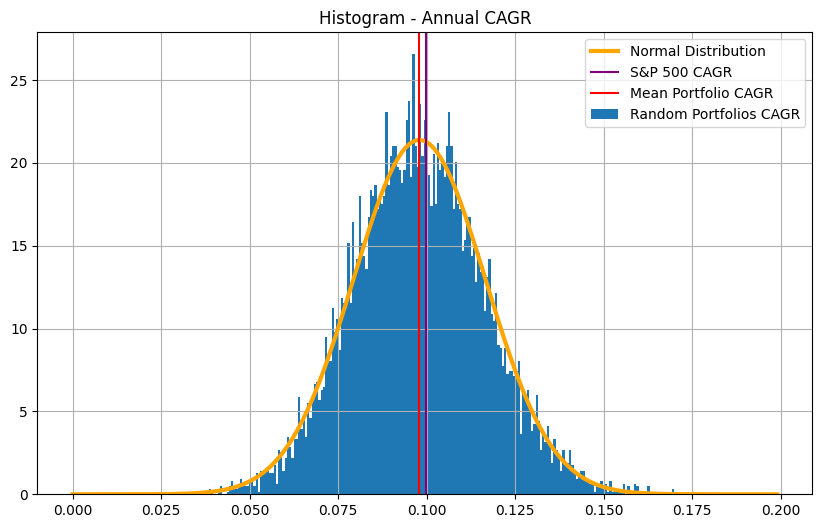

In [19]:
### histogram cagr portfolioa

fig,ax1 = plt.subplots(1,figsize=(10,6))

x = np.arange(0, 0.2, 0.001) 

mu, std = norm.fit(metrics["Annual Return"])

ax1.plot(x, norm.pdf(x, mu, std),color="orange",linewidth=3,label="Normal Distribution")

ax1.hist(metrics["Annual Return"],bins=222,cumulative=False,density=True,label="Random Portfolios CAGR");
ax1.grid(True)
ax1.axvline(metrics["Annual Return"]["SPX"],color="purple",linewidth=1.5,label="S&P 500 CAGR");
ax1.axvline(metrics["Annual Return"][0:10000].mean(),color="red",linewidth=1.5,label="Mean Portfolio CAGR");
#plt.axvline(metrics["Annual Return"][0:10000].median(),color="lightgreen",linewidth=1.5,label="Median Portfolio CAGR");
ax1.set_title("Histogram - Annual CAGR");
ax1.legend();

plt.savefig("Graphs/Histogram_CAGR.png")

In [20]:
ff = pd.read_csv("F-F_Research_Data_5_Factors_2x3.CSV",skiprows=3,index_col=0,skipfooter=63,engine="python",parse_dates=True,infer_datetime_format=True)

ff.index = pd.to_datetime(ff.index, format= '%Y%m')
ff.index = ff.index + pd.offsets.MonthEnd()
ff = ff["1996-03":"2021"]
ff = ff/100

ff.rename(columns={"Mkt-RF":"mkt_excess"}, inplace=True)

In [ ]:
###### cálculo factores por periodo PORTFOLIOS

from statsmodels.regression.rolling import RollingOLS

factorsp1 = pd.DataFrame(columns=returns[range(0,10000)].columns,index=["Alpha","Beta","SMB","HML","RMW","CMA","R2","P-value Alpha"])


for i in returns[range(0,10000)].columns:

        endog = returns[i]["1998":"2003"].dropna() - ff["RF"]["1998":"2003"]
        exog = ff[["mkt_excess","SMB","HML","RMW","CMA"]]["1998":"2003"]
        exog = sm.add_constant(exog)

        mod = sm.regression.linear_model.OLS(endog,exog)
        rres = mod.fit()
        
        factorsp1.loc["Alpha"][i] = rres.params["const"]
        factorsp1.loc["Beta"][i] = rres.params["mkt_excess"]
        factorsp1.loc["SMB"][i] = rres.params["SMB"]
        factorsp1.loc["HML"][i] = rres.params["HML"]
        factorsp1.loc["RMW"][i] = rres.params["RMW"]
        factorsp1.loc["CMA"][i] = rres.params["CMA"]
        factorsp1.loc["R2"][i] = rres.rsquared
        factorsp1.loc["P-value Alpha"][i] = rres.pvalues["const"]

factorsp2 = pd.DataFrame(columns=returns[range(0,10000)].columns,index=["Alpha","Beta","SMB","HML","RMW","CMA","R2","P-value Alpha"])


for i in returns[range(0,10000)].columns:

        endog = returns[i]["2004":"2007"].dropna() - ff["RF"]["2004":"2007"]
        exog = ff[["mkt_excess","SMB","HML","RMW","CMA"]]["2004":"2007"]
        exog = sm.add_constant(exog)

        mod = sm.regression.linear_model.OLS(endog,exog)
        rres = mod.fit()
        
        factorsp2.loc["Alpha"][i] = rres.params["const"]
        factorsp2.loc["Beta"][i] = rres.params["mkt_excess"]
        factorsp2.loc["SMB"][i] = rres.params["SMB"]
        factorsp2.loc["HML"][i] = rres.params["HML"]
        factorsp2.loc["RMW"][i] = rres.params["RMW"]
        factorsp2.loc["CMA"][i] = rres.params["CMA"]
        factorsp2.loc["R2"][i] = rres.rsquared
        factorsp2.loc["P-value Alpha"][i] = rres.pvalues["const"]


factorsp3 = pd.DataFrame(columns=returns[range(0,10000)].columns,index=["Alpha","Beta","SMB","HML","RMW","CMA","R2","P-value Alpha"])


for i in returns[range(0,10000)].columns:

        endog = returns[i]["2008":"2012"].dropna() - ff["RF"]["2008":"2012"]
        exog = ff[["mkt_excess","SMB","HML","RMW","CMA"]]["2008":"2012"]
        exog = sm.add_constant(exog)

        mod = sm.regression.linear_model.OLS(endog,exog)
        rres = mod.fit()
        
        factorsp3.loc["Alpha"][i] = rres.params["const"]
        factorsp3.loc["Beta"][i] = rres.params["mkt_excess"]
        factorsp3.loc["SMB"][i] = rres.params["SMB"]
        factorsp3.loc["HML"][i] = rres.params["HML"]
        factorsp3.loc["RMW"][i] = rres.params["RMW"]
        factorsp3.loc["CMA"][i] = rres.params["CMA"]
        factorsp3.loc["R2"][i] = rres.rsquared
        factorsp3.loc["P-value Alpha"][i] = rres.pvalues["const"]


factorsp4 = pd.DataFrame(columns=returns[range(0,10000)].columns,index=["Alpha","Beta","SMB","HML","RMW","CMA","R2","P-value Alpha"])


for i in returns[range(0,10000)].columns:

        endog = returns[i]["2013":"2017"].dropna() - ff["RF"]["2013":"2017"]
        exog = ff[["mkt_excess","SMB","HML","RMW","CMA"]]["2013":"2017"]
        exog = sm.add_constant(exog)

        mod = sm.regression.linear_model.OLS(endog,exog)
        rres = mod.fit()
        
        factorsp4.loc["Alpha"][i] = rres.params["const"]
        factorsp4.loc["Beta"][i] = rres.params["mkt_excess"]
        factorsp4.loc["SMB"][i] = rres.params["SMB"]
        factorsp4.loc["HML"][i] = rres.params["HML"]
        factorsp4.loc["RMW"][i] = rres.params["RMW"]
        factorsp4.loc["CMA"][i] = rres.params["CMA"]
        factorsp4.loc["R2"][i] = rres.rsquared
        factorsp4.loc["P-value Alpha"][i] = rres.pvalues["const"]


factorsp5 = pd.DataFrame(columns=returns[range(0,10000)].columns,index=["Alpha","Beta","SMB","HML","RMW","CMA","R2","P-value Alpha"])


for i in returns[range(0,10000)].columns:

        endog = returns[i]["2018":"2021"].dropna() - ff["RF"]["2018":"2021"]
        exog = ff[["mkt_excess","SMB","HML","RMW","CMA"]]["2018":"2021"]
        exog = sm.add_constant(exog)

        mod = sm.regression.linear_model.OLS(endog,exog)
        rres = mod.fit()
        
        factorsp5.loc["Alpha"][i] = rres.params["const"]
        factorsp5.loc["Beta"][i] = rres.params["mkt_excess"]
        factorsp5.loc["SMB"][i] = rres.params["SMB"]
        factorsp5.loc["HML"][i] = rres.params["HML"]
        factorsp5.loc["RMW"][i] = rres.params["RMW"]
        factorsp5.loc["CMA"][i] = rres.params["CMA"]
        factorsp5.loc["R2"][i] = rres.rsquared
        factorsp5.loc["P-value Alpha"][i] = rres.pvalues["const"]

factorsp1.to_csv("Computations/factorsp1.csv")
factorsp2.to_csv("Computations/factorsp2.csv")
factorsp3.to_csv("Computations/factorsp3.csv")
factorsp4.to_csv("Computations/factorsp4.csv")
factorsp5.to_csv("Computations/factorsp5.csv")

In [21]:
funds = pd.read_excel("Reuters Mutual Fund Data.xlsx")

tickers = list(funds[funds["Index Based Fund"]!=1]["NASDAQ Ticker"].dropna())

data_f = yf.download(tickers,start="1995-12-31",end="2022-01-01",threads=4,periods="1mo")["Adj Close"]
data_f = data_f.resample("M").pad().pct_change()

In [ ]:
### numero fondos disponibles según año

#data_f.count(axis=1).plot(title="Number of funds available per year",figsize=(8,4),linewidth=3)

fig,ax1 = plt.subplots(1,figsize=(10,6))

ax1.plot(data_f.count(axis=1),label="Number of funds",linewidth=3)
ax1.set_xlabel("Year");
ax1.set_ylabel("Number of funds");
ax1.grid(True);
ax1.legend();
ax1.set_title("Number of funds available per year");
plt.savefig("Graphs/numfunds.png",dpi=300);

In [ ]:

factorsfp1 = pd.DataFrame(columns=data_f.columns,index=["Alpha","Beta","SMB","HML","RMW","CMA","R2","P-value Alpha"])


for i in data_f.columns:

        endog = data_f[i]["1998":"2003"].dropna() - ff["RF"]["1998":"2003"]
        exog = ff[["mkt_excess","SMB","HML","RMW","CMA"]]["1998":"2003"]
        exog = sm.add_constant(exog)

        mod = sm.regression.linear_model.OLS(endog,exog)
        rres = mod.fit()
        
        factorsfp1.loc["Alpha"][i] = rres.params["const"]
        factorsfp1.loc["Beta"][i] = rres.params["mkt_excess"]
        factorsfp1.loc["SMB"][i] = rres.params["SMB"]
        factorsfp1.loc["HML"][i] = rres.params["HML"]
        factorsfp1.loc["RMW"][i] = rres.params["RMW"]
        factorsfp1.loc["CMA"][i] = rres.params["CMA"]
        factorsfp1.loc["R2"][i] = rres.rsquared
        factorsfp1.loc["P-value Alpha"][i] = rres.pvalues["const"]

factorsfp2 = pd.DataFrame(columns=data_f.columns,index=["Alpha","Beta","SMB","HML","RMW","CMA","R2","P-value Alpha"])


for i in data_f.columns:

        endog = data_f[i]["2004":"2007"].dropna() - ff["RF"]["2004":"2007"]
        exog = ff[["mkt_excess","SMB","HML","RMW","CMA"]]["2004":"2007"]
        exog = sm.add_constant(exog)

        mod = sm.regression.linear_model.OLS(endog,exog)
        rres = mod.fit()
        
        factorsfp2.loc["Alpha"][i] = rres.params["const"]
        factorsfp2.loc["Beta"][i] = rres.params["mkt_excess"]
        factorsfp2.loc["SMB"][i] = rres.params["SMB"]
        factorsfp2.loc["HML"][i] = rres.params["HML"]
        factorsfp2.loc["RMW"][i] = rres.params["RMW"]
        factorsfp2.loc["CMA"][i] = rres.params["CMA"]
        factorsfp2.loc["R2"][i] = rres.rsquared
        factorsfp2.loc["P-value Alpha"][i] = rres.pvalues["const"]

factorsfp3 = pd.DataFrame(columns=data_f.columns,index=["Alpha","Beta","SMB","HML","RMW","CMA","R2","P-value Alpha"])


for i in data_f.columns:

        endog = data_f[i]["2008":"2012"].dropna() - ff["RF"]["2008":"2012"]
        exog = ff[["mkt_excess","SMB","HML","RMW","CMA"]]["2008":"2012"]
        exog = sm.add_constant(exog)

        mod = sm.regression.linear_model.OLS(endog,exog)
        rres = mod.fit()
        
        factorsfp3.loc["Alpha"][i] = rres.params["const"]
        factorsfp3.loc["Beta"][i] = rres.params["mkt_excess"]
        factorsfp3.loc["SMB"][i] = rres.params["SMB"]
        factorsfp3.loc["HML"][i] = rres.params["HML"]
        factorsfp3.loc["RMW"][i] = rres.params["RMW"]
        factorsfp3.loc["CMA"][i] = rres.params["CMA"]
        factorsfp3.loc["R2"][i] = rres.rsquared
        factorsfp3.loc["P-value Alpha"][i] = rres.pvalues["const"]


factorsfp4 = pd.DataFrame(columns=data_f.columns,index=["Alpha","Beta","SMB","HML","RMW","CMA","R2","P-value Alpha"])


for i in data_f.columns:

        endog = data_f[i]["2013":"2017"].dropna() - ff["RF"]["2013":"2017"]
        exog = ff[["mkt_excess","SMB","HML","RMW","CMA"]]["2013":"2017"]
        exog = sm.add_constant(exog)

        mod = sm.regression.linear_model.OLS(endog,exog)
        rres = mod.fit()
        
        factorsfp4.loc["Alpha"][i] = rres.params["const"]
        factorsfp4.loc["Beta"][i] = rres.params["mkt_excess"]
        factorsfp4.loc["SMB"][i] = rres.params["SMB"]
        factorsfp4.loc["HML"][i] = rres.params["HML"]
        factorsfp4.loc["RMW"][i] = rres.params["RMW"]
        factorsfp4.loc["CMA"][i] = rres.params["CMA"]
        factorsfp4.loc["R2"][i] = rres.rsquared
        factorsfp4.loc["P-value Alpha"][i] = rres.pvalues["const"]


factorsfp5 = pd.DataFrame(columns=data_f.columns,index=["Alpha","Beta","SMB","HML","RMW","CMA","R2","P-value Alpha"])


for i in data_f.columns:

        endog = data_f[i]["2018":"2021"].dropna() - ff["RF"]["2018":"2021"]
        exog = ff[["mkt_excess","SMB","HML","RMW","CMA"]]["2018":"2021"]
        exog = sm.add_constant(exog)

        mod = sm.regression.linear_model.OLS(endog,exog)
        rres = mod.fit()
        
        factorsfp5.loc["Alpha"][i] = rres.params["const"]
        factorsfp5.loc["Beta"][i] = rres.params["mkt_excess"]
        factorsfp5.loc["SMB"][i] = rres.params["SMB"]
        factorsfp5.loc["HML"][i] = rres.params["HML"]
        factorsfp5.loc["RMW"][i] = rres.params["RMW"]
        factorsfp5.loc["CMA"][i] = rres.params["CMA"]
        factorsfp5.loc["R2"][i] = rres.rsquared
        factorsfp5.loc["P-value Alpha"][i] = rres.pvalues["const"]


factorsfp1.to_csv("Computations/factorsfp1.csv")
factorsfp2.to_csv("Computations/factorsfp2.csv")
factorsfp3.to_csv("Computations/factorsfp3.csv")
factorsfp4.to_csv("Computations/factorsfp4.csv")
factorsfp5.to_csv("Computations/factorsfp5.csv")

In [23]:
factorsfp1 = pd.read_csv("Computations/factorsfp1.csv",index_col=0,parse_dates=True)
factorsfp2 = pd.read_csv("Computations/factorsfp2.csv",index_col=0,parse_dates=True)
factorsfp3 = pd.read_csv("Computations/factorsfp3.csv",index_col=0,parse_dates=True)
factorsfp4 = pd.read_csv("Computations/factorsfp4.csv",index_col=0,parse_dates=True)
factorsfp5 = pd.read_csv("Computations/factorsfp5.csv",index_col=0,parse_dates=True)


factorsp1 = pd.read_csv("Computations/factorsp1.csv",index_col=0)
factorsp2 = pd.read_csv("Computations/factorsp2.csv",index_col=0)
factorsp3 = pd.read_csv("Computations/factorsp3.csv",index_col=0)
factorsp4 = pd.read_csv("Computations/factorsp4.csv",index_col=0)
factorsp5 = pd.read_csv("Computations/factorsp5.csv",index_col=0)


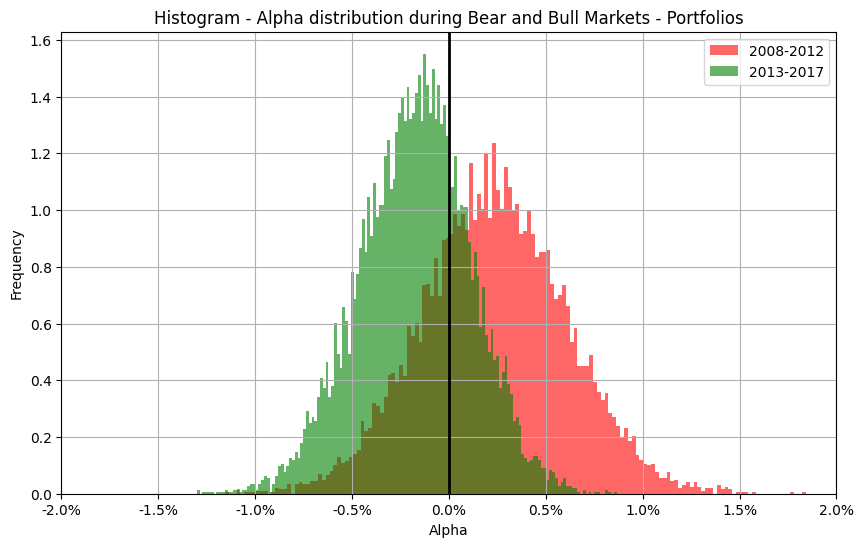

In [26]:
######## histograma distribucion alphas portfolios segun mercado

import matplotlib.ticker as mtick

fig,ax1 = plt.subplots(1,figsize=(10,6))

plt.hist(factorsp3.loc["Alpha"]*100,bins=150,alpha=0.6,label="2008-2012",color="red",density=True);
plt.hist(factorsp4.loc["Alpha"]*100,bins=150,alpha=0.6,label="2013-2017",color="green",density=True);
#plt.hist(factorsp3.loc["Alpha"],bins=100,alpha=0.3,label="2008-2012",color="#21235c");
plt.grid(True);
plt.legend();
plt.xlim((-2,2))
plt.axvline(0,color="black",linewidth=2);
plt.title("Histogram - Alpha distribution during Bear and Bull Markets - Portfolios");
plt.xlabel("Alpha");
plt.ylabel("Frequency");

fmt = '%.1f%%' # Format you want the ticks, e.g. '40%'
xticks = mtick.FormatStrFormatter(fmt)
ax1.xaxis.set_major_formatter(xticks)

plt.savefig("Graphs/hist_alpha_portfolios.png",dpi=300);


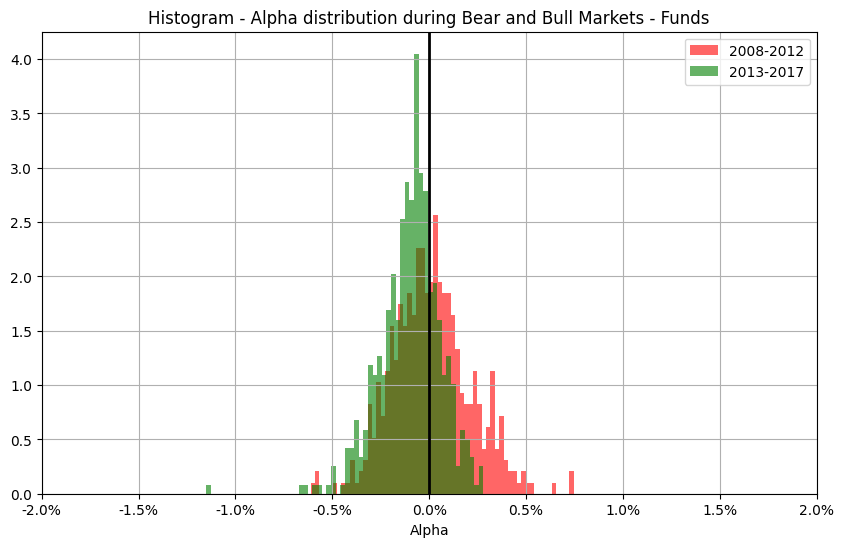

In [27]:
######## histograma distribucion alphas funds segun mercado

fig,ax1 = plt.subplots(1,figsize=(10,6))

plt.hist(factorsfp3.loc["Alpha"]*100,bins=60,alpha=0.6,label="2008-2012",color="red",density=True);
plt.hist(factorsfp4.loc["Alpha"]*100,bins=60,alpha=0.6,label="2013-2017",color="green",density=True);
plt.grid(True);
plt.legend();
plt.xlim((-2,2))
plt.axvline(0,color="black",linewidth=2);
plt.title("Histogram - Alpha distribution during Bear and Bull Markets - Funds");
plt.xlabel("Alpha");


fmt = '%.1f%%' # Format you want the ticks, e.g. '40%'
xticks = mtick.FormatStrFormatter(fmt)
ax1.xaxis.set_major_formatter(xticks)

plt.savefig("Graphs/hist_alpha_funds.png",dpi=300);

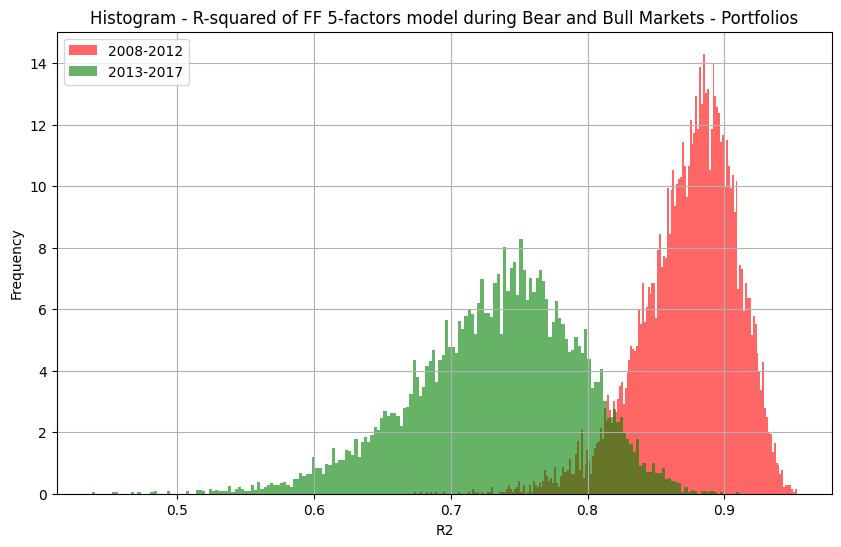

In [29]:
######## histograma distribucion alphas carteras segun mercado

fig,ax1 = plt.subplots(1,figsize=(10,6))

plt.hist(factorsp3.loc["R2"],bins=200,alpha=0.6,label="2008-2012",color="red",density=True);
plt.hist(factorsp4.loc["R2"],bins=200,alpha=0.6,label="2013-2017",color="green",density=True);
#plt.hist(factorsp3.loc["Alpha"],bins=100,alpha=0.3,label="2008-2012",color="#21235c");
plt.grid(True);
plt.legend();
ax1.set_ylabel("Frequency");
ax1.set_xlabel("R2");
#plt.xlim((-0.02,0.02))
#plt.axvline(0,color="black",linewidth=2);
plt.title("Histogram - R-squared of FF 5-factors model during Bear and Bull Markets - Portfolios");
plt.savefig("Graphs/hist_r2_ff_portfolios.png",dpi=300);


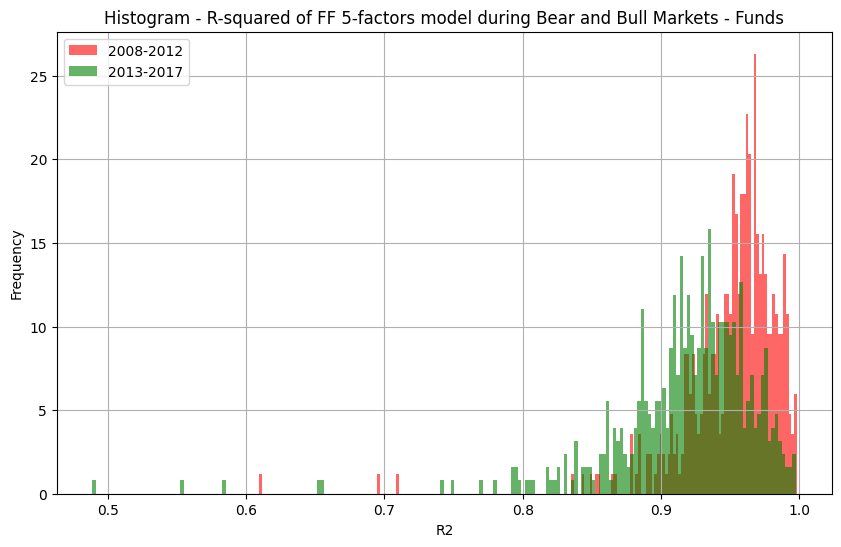

In [28]:
######## histograma distribucion alphas fondos segun mercado

fig,ax1 = plt.subplots(1,figsize=(10,6))

plt.hist(factorsfp3.loc["R2"],bins=200,alpha=0.6,label="2008-2012",color="red",density=True);
plt.hist(factorsfp4.loc["R2"],bins=200,alpha=0.6,label="2013-2017",color="green",density=True);
#plt.hist(factorsp3.loc["Alpha"],bins=100,alpha=0.3,label="2008-2012",color="#21235c");
plt.grid(True);
plt.legend();
ax1.set_ylabel("Frequency");
ax1.set_xlabel("R2");
#plt.xlim((-0.02,0.02))
#plt.axvline(0,color="black",linewidth=2);
plt.title("Histogram - R-squared of FF 5-factors model during Bear and Bull Markets - Funds");
plt.savefig("Graphs/hist_r2_ff_funds.png",dpi=300);

In [30]:
#### calculo correlaciones de carteras simuladas y fondos con sp500
 
correlations_with_spx = returns.iloc[:,:-2].rolling(12).corr(returns.iloc[:,-2])


correlations_with_spx["P1"] = np.nan
correlations_with_spx["P1"]["1998":"2003"]= correlations_with_spx["1998":"2003"].mean(axis=1).mean()
correlations_with_spx["P2"] = np.nan
correlations_with_spx["P2"]["2004":"2007"]= correlations_with_spx["2004":"2007"].mean(axis=1).mean()
correlations_with_spx["P3"] = np.nan
correlations_with_spx["P3"]["2008":"2012"]= correlations_with_spx["2008":"2012"].mean(axis=1).mean()
correlations_with_spx["P4"] = np.nan
correlations_with_spx["P4"]["2013":"2017"]= correlations_with_spx["2013":"2017"].mean(axis=1).mean()
correlations_with_spx["P5"] = np.nan
correlations_with_spx["P5"]["2018":"2021"]= correlations_with_spx["2018":"2021"].mean(axis=1).mean()

correlations_with_spx = correlations_with_spx.dropna(axis=1,how="all")


data_f_corr = data_f
data_f_corr["SPX"] = returns["SPX"]
data_f_corr 


correlations_with_spx_funds = data_f_corr.iloc[:,:-1].rolling(12).corr(data_f_corr.iloc[:,-1])


correlations_with_spx_funds["P1"] = np.nan
correlations_with_spx_funds["P1"]["1998":"2003"]= correlations_with_spx_funds["1998":"2003"].mean(axis=1).mean()
correlations_with_spx_funds["P2"] = np.nan
correlations_with_spx_funds["P2"]["2004":"2007"]= correlations_with_spx_funds["2004":"2007"].mean(axis=1).mean()
correlations_with_spx_funds["P3"] = np.nan
correlations_with_spx_funds["P3"]["2008":"2012"]= correlations_with_spx_funds["2008":"2012"].mean(axis=1).mean()
correlations_with_spx_funds["P4"] = np.nan
correlations_with_spx_funds["P4"]["2013":"2017"]= correlations_with_spx_funds["2013":"2017"].mean(axis=1).mean()
correlations_with_spx_funds["P5"] = np.nan
correlations_with_spx_funds["P5"]["2018":"2021"]= correlations_with_spx_funds["2018":"2021"].mean(axis=1).mean()

correlations_with_spx_funds = correlations_with_spx_funds.dropna(axis=1,how="all")


fig,ax1 = plt.subplots(1,figsize=(10,6))
ax1.plot(correlations_with_spx.mean(axis=1),label="Portfolio Correlations with SPX");
ax1.plot(correlations_with_spx_funds.mean(axis=1),label="Funds Correlations with SPX");
ax1.set_title("Rolling 12-month correlation with S&P 500")


ax1.plot(correlations_with_spx.index,correlations_with_spx["P1"].values,linewidth=4,color="red");
ax1.plot(correlations_with_spx.index,correlations_with_spx["P2"].values,linewidth=4,color="lightgreen");
ax1.plot(correlations_with_spx.index,correlations_with_spx["P3"].values,linewidth=4,color="red");
ax1.plot(correlations_with_spx.index,correlations_with_spx["P4"].values,linewidth=4,color="lightgreen");
ax1.plot(correlations_with_spx.index,correlations_with_spx["P5"].values,linewidth=4,color="red");

ax1.plot(correlations_with_spx_funds.index,correlations_with_spx_funds["P1"].values,label="1998-2003",linewidth=4,color="red");
ax1.plot(correlations_with_spx_funds.index,correlations_with_spx_funds["P2"].values,label="2004-2007",linewidth=4,color="lightgreen");
ax1.plot(correlations_with_spx_funds.index,correlations_with_spx_funds["P3"].values,label="2008-2012",linewidth=4,color="red");
ax1.plot(correlations_with_spx_funds.index,correlations_with_spx_funds["P4"].values,label="2013-2017",linewidth=4,color="lightgreen");
ax1.plot(correlations_with_spx_funds.index,correlations_with_spx_funds["P5"].values,label="2018-2021",linewidth=4,color="red");

ax1.legend();
ax1.set_ylim((0.4,1))

ax1.set_xlabel("Year")
ax1.set_ylabel("Correlation")
ax1.grid(True)
plt.savefig("Graphs/correlation_with_spx.png",dpi=300)

NameError: name 'data_f' is not defined

In [ ]:
########### rolling regression de 12 meses para cada CARTERA, por periodos


alpha5f_portfoliosp1 = pd.DataFrame(columns=returns["1998":"2003"].dropna(axis=1).columns,index=returns.index)["1998":"2003"]
beta5f_portfoliosp1 = pd.DataFrame(columns=returns["1998":"2003"].dropna(axis=1).columns,index=returns.index)["1998":"2003"]

for i in alpha5f_portfoliosp1.columns:
        ff_ = ff.copy()["1998":"2003"]
        ff_[i] = returns[i]["1998":"2003"]
        ff_["Excess"] = ff_[i] - ff_["RF"]
        mod = RollingOLS.from_formula("Excess ~ mkt_excess + SMB + HML + RMW + CMA",window=12,data=ff_)
        rres = mod.fit()
        alpha5f_portfoliosp1[i] = rres.params["Intercept"]
        beta5f_portfoliosp1[i] = rres.params["mkt_excess"]


alpha5f_portfoliosp2 = pd.DataFrame(columns=returns["2004":"2007"].dropna(axis=1).columns,index=returns.index)["2004":"2007"]
beta5f_portfoliosp2 = pd.DataFrame(columns=returns["2004":"2007"].dropna(axis=1).columns,index=returns.index)["2004":"2007"]

for i in alpha5f_portfoliosp2.columns:
        ff_ = ff.copy()["2004":"2007"]
        ff_[i] = returns[i]["2004":"2007"]
        ff_["Excess"] = ff_[i] - ff_["RF"]
        mod = RollingOLS.from_formula("Excess ~ mkt_excess + SMB + HML + RMW + CMA",window=12,data=ff_)
        rres = mod.fit()
        alpha5f_portfoliosp2[i] = rres.params["Intercept"]
        beta5f_portfoliosp2[i] = rres.params["mkt_excess"]

alpha5f_portfoliosp3 = pd.DataFrame(columns=returns["2008":"2012"].dropna(axis=1).columns,index=returns.index)["2008":"2012"]
beta5f_portfoliosp3 = pd.DataFrame(columns=returns["2008":"2012"].dropna(axis=1).columns,index=returns.index)["2008":"2012"]

for i in alpha5f_portfoliosp3.columns:
        ff_ = ff.copy()["2008":"2012"]
        ff_[i] = returns[i]["2008":"2012"]
        ff_["Excess"] = ff_[i] - ff_["RF"]
        mod = RollingOLS.from_formula("Excess ~ mkt_excess + SMB + HML + RMW + CMA",window=12,data=ff_)
        rres = mod.fit()
        alpha5f_portfoliosp3[i] = rres.params["Intercept"]
        beta5f_portfoliosp3[i] = rres.params["mkt_excess"]

alpha5f_portfoliosp4 = pd.DataFrame(columns=returns["2013":"2017"].dropna(axis=1).columns,index=returns.index)["2013":"2017"]
beta5f_portfoliosp4 = pd.DataFrame(columns=returns["2013":"2017"].dropna(axis=1).columns,index=returns.index)["2013":"2017"]

for i in alpha5f_portfoliosp4.columns:
        ff_ = ff.copy()["2013":"2017"]
        ff_[i] = returns[i]["2013":"2017"]
        ff_["Excess"] = ff_[i] - ff_["RF"]
        mod = RollingOLS.from_formula("Excess ~ mkt_excess + SMB + HML + RMW + CMA",window=12,data=ff_)
        rres = mod.fit()
        alpha5f_portfoliosp4[i] = rres.params["Intercept"]
        beta5f_portfoliosp4[i] = rres.params["mkt_excess"]

alpha5f_portfoliosp5 = pd.DataFrame(columns=returns["2018":"2021"].dropna(axis=1).columns,index=returns.index)["2018":"2021"]
beta5f_portfoliosp5 = pd.DataFrame(columns=returns["2018":"2021"].dropna(axis=1).columns,index=returns.index)["2018":"2021"]

for i in alpha5f_portfoliosp5.columns:
        ff_ = ff.copy()["2018":"2021"]
        ff_[i] = returns[i]["2018":"2021"]
        ff_["Excess"] = ff_[i] - ff_["RF"]
        mod = RollingOLS.from_formula("Excess ~ mkt_excess + SMB + HML + RMW + CMA",window=12,data=ff_)
        rres = mod.fit()
        alpha5f_portfoliosp5[i] = rres.params["Intercept"]
        beta5f_portfoliosp5[i] = rres.params["mkt_excess"]


alpha5f_portfoliosp1.to_csv("Computations/alpha5f_portfoliosp1.csv")
alpha5f_portfoliosp2.to_csv("Computations/alpha5f_portfoliosp2.csv")
alpha5f_portfoliosp3.to_csv("Computations/alpha5f_portfoliosp3.csv")
alpha5f_portfoliosp4.to_csv("Computations/alpha5f_portfoliosp4.csv")
alpha5f_portfoliosp5.to_csv("Computations/alpha5f_portfoliosp5.csv")

beta5f_portfoliosp1.to_csv("Computations/beta5f_portfoliosp1.csv")
beta5f_portfoliosp2.to_csv("Computations/beta5f_portfoliosp2.csv")
beta5f_portfoliosp3.to_csv("Computations/beta5f_portfoliosp3.csv")
beta5f_portfoliosp4.to_csv("Computations/beta5f_portfoliosp4.csv")
beta5f_portfoliosp5.to_csv("Computations/beta5f_portfoliosp5.csv")


In [ ]:
########### rolling regression de 12 meses para cada FONDO, por periodos

alpha5f_fundsp1 = pd.DataFrame(columns=data_f["1998":"2003"].dropna(axis=1).columns,index=data_f.index)["1998":"2003"]
beta5f_fundsp1 = pd.DataFrame(columns=data_f["1998":"2003"].dropna(axis=1).columns,index=data_f.index)["1998":"2003"]

for i in alpha5f_fundsp1.columns:
        ff_ = ff.copy()["1998":"2003"]
        ff_[i] = data_f[i]["1998":"2003"]
        ff_["Excess"] = ff_[i] - ff_["RF"]
        mod = RollingOLS.from_formula("Excess ~ mkt_excess + SMB + HML + RMW + CMA",window=12,data=ff_)
        rres = mod.fit()
        alpha5f_fundsp1[i] = rres.params["Intercept"]
        beta5f_fundsp1[i] = rres.params["mkt_excess"]
        #Intercept	mkt_excess	SMB	HML



alpha5f_fundsp2 = pd.DataFrame(columns=data_f["2004":"2007"].dropna(axis=1).columns,index=data_f.index)["2004":"2007"]
beta5f_fundsp2 = pd.DataFrame(columns=data_f["2004":"2007"].dropna(axis=1).columns,index=data_f.index)["2004":"2007"]

for i in alpha5f_fundsp2.columns:
        ff_ = ff.copy()["2004":"2007"]
        ff_[i] = data_f[i]["2004":"2007"]
        ff_["Excess"] = ff_[i] - ff_["RF"]
        mod = RollingOLS.from_formula("Excess ~ mkt_excess + SMB + HML + RMW + CMA",window=12,data=ff_)
        rres = mod.fit()
        alpha5f_fundsp2[i] = rres.params["Intercept"]
        beta5f_fundsp2[i] = rres.params["mkt_excess"]

        #Intercept	mkt_excess	SMB	HML


alpha5f_fundsp3 = pd.DataFrame(columns=data_f["2008":"2012"].dropna(axis=1).columns,index=data_f.index)["2008":"2012"]
beta5f_fundsp3 = pd.DataFrame(columns=data_f["2008":"2012"].dropna(axis=1).columns,index=data_f.index)["2008":"2012"]


for i in alpha5f_fundsp3.columns:
        ff_ = ff.copy()["2008":"2012"]
        ff_[i] = data_f[i]["2008":"2012"]
        ff_["Excess"] = ff_[i] - ff_["RF"]
        mod = RollingOLS.from_formula("Excess ~ mkt_excess + SMB + HML + RMW + CMA",window=12,data=ff_)
        rres = mod.fit()
        alpha5f_fundsp3[i] = rres.params["Intercept"]
        beta5f_fundsp3[i] = rres.params["mkt_excess"]

        #Intercept	mkt_excess	SMB	HML


alpha5f_fundsp4 = pd.DataFrame(columns=data_f["2013":"2017"].dropna(axis=1).columns,index=data_f.index)["2013":"2017"]
beta5f_fundsp4 = pd.DataFrame(columns=data_f["2013":"2017"].dropna(axis=1).columns,index=data_f.index)["2013":"2017"]

for i in alpha5f_fundsp4.columns:
        ff_ = ff.copy()["2013":"2017"]
        ff_[i] = data_f[i]["2013":"2017"]
        ff_["Excess"] = ff_[i] - ff_["RF"]
        mod = RollingOLS.from_formula("Excess ~ mkt_excess + SMB + HML + RMW + CMA",window=12,data=ff_)
        rres = mod.fit()
        alpha5f_fundsp4[i] = rres.params["Intercept"]
        beta5f_fundsp4[i] = rres.params["mkt_excess"]

        #Intercept	mkt_excess	SMB	HML



alpha5f_fundsp5 = pd.DataFrame(columns=data_f["2018":"2021"].dropna(axis=1).columns,index=data_f.index)["2018":"2021"]
beta5f_fundsp5 = pd.DataFrame(columns=data_f["2018":"2021"].dropna(axis=1).columns,index=data_f.index)["2018":"2021"]

for i in alpha5f_fundsp5.columns:
        ff_ = ff.copy()["2018":"2021"]
        ff_[i] = data_f[i]["2018":"2021"]
        ff_["Excess"] = ff_[i] - ff_["RF"]
        mod = RollingOLS.from_formula("Excess ~ mkt_excess + SMB + HML + RMW + CMA",window=12,data=ff_)
        rres = mod.fit()
        alpha5f_fundsp5[i] = rres.params["Intercept"]
        beta5f_fundsp5[i] = rres.params["mkt_excess"]
        #Intercept	mkt_excess	SMB	HML



alpha5f_fundsp1.to_csv("Computations/alpha5f_fundsp1.csv")
alpha5f_fundsp2.to_csv("Computations/alpha5f_fundsp2.csv")
alpha5f_fundsp3.to_csv("Computations/alpha5f_fundsp3.csv")
alpha5f_fundsp4.to_csv("Computations/alpha5f_fundsp4.csv")
alpha5f_fundsp5.to_csv("Computations/alpha5f_fundsp5.csv")

beta5f_fundsp1.to_csv("Computations/beta5f_fundsp1.csv")
beta5f_fundsp2.to_csv("Computations/beta5f_fundsp2.csv")
beta5f_fundsp3.to_csv("Computations/beta5f_fundsp3.csv")
beta5f_fundsp4.to_csv("Computations/beta5f_fundsp4.csv")
beta5f_fundsp5.to_csv("Computations/beta5f_fundsp5.csv")

In [34]:
alpha5f_fundsp1 = pd.read_csv("Computations/alpha5f_fundsp1.csv",index_col=0,parse_dates=True)
alpha5f_fundsp2 = pd.read_csv("Computations/alpha5f_fundsp2.csv",index_col=0,parse_dates=True)
alpha5f_fundsp3 = pd.read_csv("Computations/alpha5f_fundsp3.csv",index_col=0,parse_dates=True)
alpha5f_fundsp4 = pd.read_csv("Computations/alpha5f_fundsp4.csv",index_col=0,parse_dates=True)
alpha5f_fundsp5 = pd.read_csv("Computations/alpha5f_fundsp5.csv",index_col=0,parse_dates=True)

beta5f_fundsp1 = pd.read_csv("Computations/beta5f_fundsp1.csv",index_col=0,parse_dates=True)
beta5f_fundsp2 = pd.read_csv("Computations/beta5f_fundsp2.csv",index_col=0,parse_dates=True)
beta5f_fundsp3 = pd.read_csv("Computations/beta5f_fundsp3.csv",index_col=0,parse_dates=True)
beta5f_fundsp4 = pd.read_csv("Computations/beta5f_fundsp4.csv",index_col=0,parse_dates=True)
beta5f_fundsp5 = pd.read_csv("Computations/beta5f_fundsp5.csv",index_col=0,parse_dates=True)

alpha5f_portfoliosp1 = pd.read_csv("Computations/alpha5f_portfoliosp1.csv",index_col=0,parse_dates=True)
alpha5f_portfoliosp2 = pd.read_csv("Computations/alpha5f_portfoliosp2.csv",index_col=0,parse_dates=True)
alpha5f_portfoliosp3 = pd.read_csv("Computations/alpha5f_portfoliosp3.csv",index_col=0,parse_dates=True)
alpha5f_portfoliosp4 = pd.read_csv("Computations/alpha5f_portfoliosp4.csv",index_col=0,parse_dates=True)
alpha5f_portfoliosp5 = pd.read_csv("Computations/alpha5f_portfoliosp5.csv",index_col=0,parse_dates=True)

beta5f_portfoliosp1 = pd.read_csv("Computations/beta5f_portfoliosp1.csv",index_col=0,parse_dates=True)
beta5f_portfoliosp2 = pd.read_csv("Computations/beta5f_portfoliosp2.csv",index_col=0,parse_dates=True)
beta5f_portfoliosp3 = pd.read_csv("Computations/beta5f_portfoliosp3.csv",index_col=0,parse_dates=True)
beta5f_portfoliosp4 = pd.read_csv("Computations/beta5f_portfoliosp4.csv",index_col=0,parse_dates=True)
beta5f_portfoliosp5 = pd.read_csv("Computations/beta5f_portfoliosp5.csv",index_col=0,parse_dates=True)

In [ ]:
### betas de los fondos con alpha

alpha5f_bybetas_fundsp1 = pd.DataFrame(index=alpha5f_fundsp1.index,columns=["low","mid","high"])

for i in alpha5f_fundsp1[alpha5f_fundsp1>0].index:

    lista_alpha = alpha5f_fundsp1.loc[i][alpha5f_fundsp1.loc[i]> 0].index.to_list()

    alpha5f_bybetas_fundsp1.loc[i]["low"] = len(beta5f_fundsp1.loc[i][lista_alpha][beta5f_fundsp1.loc[i][lista_alpha] < 0.9])

    alpha5f_bybetas_fundsp1.loc[i]["high"] = len(beta5f_fundsp1.loc[i][lista_alpha][beta5f_fundsp1.loc[i][lista_alpha] > 1.1])

    alpha5f_bybetas_fundsp1.loc[i]["mid"] = len(beta5f_fundsp1.loc[i][lista_alpha][  (beta5f_fundsp1.loc[i][lista_alpha] < 1.1) & (beta5f_fundsp1.loc[i][lista_alpha] > 0.9)])


alpha5f_bybetas_fundsp2 = pd.DataFrame(index=alpha5f_fundsp2.index,columns=["low","mid","high"])

for i in alpha5f_fundsp2[alpha5f_fundsp2>0].index:

    lista_alpha = alpha5f_fundsp2.loc[i][alpha5f_fundsp2.loc[i]> 0].index.to_list()

    alpha5f_bybetas_fundsp2.loc[i]["low"] = len(beta5f_fundsp2.loc[i][lista_alpha][beta5f_fundsp2.loc[i][lista_alpha] < 0.9])

    alpha5f_bybetas_fundsp2.loc[i]["high"] = len(beta5f_fundsp2.loc[i][lista_alpha][beta5f_fundsp2.loc[i][lista_alpha] > 1.1])

    alpha5f_bybetas_fundsp2.loc[i]["mid"] = len(beta5f_fundsp2.loc[i][lista_alpha][  (beta5f_fundsp2.loc[i][lista_alpha] < 1.1) & (beta5f_fundsp2.loc[i][lista_alpha] > 0.9)])


alpha5f_bybetas_fundsp3 = pd.DataFrame(index=alpha5f_fundsp3.index,columns=["low","mid","high"])

for i in alpha5f_fundsp3[alpha5f_fundsp3>0].index:

    lista_alpha = alpha5f_fundsp3.loc[i][alpha5f_fundsp3.loc[i]> 0].index.to_list()

    alpha5f_bybetas_fundsp3.loc[i]["low"] = len(beta5f_fundsp3.loc[i][lista_alpha][beta5f_fundsp3.loc[i][lista_alpha] < 0.9])

    alpha5f_bybetas_fundsp3.loc[i]["high"] = len(beta5f_fundsp3.loc[i][lista_alpha][beta5f_fundsp3.loc[i][lista_alpha] > 1.1])

    alpha5f_bybetas_fundsp3.loc[i]["mid"] = len(beta5f_fundsp3.loc[i][lista_alpha][  (beta5f_fundsp3.loc[i][lista_alpha] < 1.1) & (beta5f_fundsp3.loc[i][lista_alpha] > 0.9)])

alpha5f_bybetas_fundsp4 = pd.DataFrame(index=alpha5f_fundsp4.index,columns=["low","mid","high"])

for i in alpha5f_fundsp4[alpha5f_fundsp4>0].index:

    lista_alpha = alpha5f_fundsp4.loc[i][alpha5f_fundsp4.loc[i]> 0].index.to_list()

    alpha5f_bybetas_fundsp4.loc[i]["low"] = len(beta5f_fundsp4.loc[i][lista_alpha][beta5f_fundsp4.loc[i][lista_alpha] < 0.9])

    alpha5f_bybetas_fundsp4.loc[i]["high"] = len(beta5f_fundsp4.loc[i][lista_alpha][beta5f_fundsp4.loc[i][lista_alpha] > 1.1])

    alpha5f_bybetas_fundsp4.loc[i]["mid"] = len(beta5f_fundsp4.loc[i][lista_alpha][  (beta5f_fundsp4.loc[i][lista_alpha] < 1.1) & (beta5f_fundsp4.loc[i][lista_alpha] > 0.9)])


alpha5f_bybetas_fundsp5 = pd.DataFrame(index=alpha5f_fundsp5.index,columns=["low","mid","high"])

for i in alpha5f_fundsp5[alpha5f_fundsp5>0].index:

    lista_alpha = alpha5f_fundsp5.loc[i][alpha5f_fundsp5.loc[i]> 0].index.to_list()

    alpha5f_bybetas_fundsp5.loc[i]["low"] = len(beta5f_fundsp5.loc[i][lista_alpha][beta5f_fundsp5.loc[i][lista_alpha] < 0.9])

    alpha5f_bybetas_fundsp5.loc[i]["high"] = len(beta5f_fundsp5.loc[i][lista_alpha][beta5f_fundsp5.loc[i][lista_alpha] > 1.1])

    alpha5f_bybetas_fundsp5.loc[i]["mid"] = len(beta5f_fundsp5.loc[i][lista_alpha][  (beta5f_fundsp5.loc[i][lista_alpha] < 1.1) & (beta5f_fundsp5.loc[i][lista_alpha] > 0.9)])


alpha5f_bybetas_fundsp1.to_csv("Computations/alpha5f_bybetas_fundsp1.csv")
alpha5f_bybetas_fundsp2.to_csv("Computations/alpha5f_bybetas_fundsp2.csv")
alpha5f_bybetas_fundsp3.to_csv("Computations/alpha5f_bybetas_fundsp3.csv")
alpha5f_bybetas_fundsp4.to_csv("Computations/alpha5f_bybetas_fundsp4.csv")
alpha5f_bybetas_fundsp5.to_csv("Computations/alpha5f_bybetas_fundsp5.csv")


In [ ]:
### betas de las carteras con alpha

alpha5f_bybetas_portfoliosp1 = pd.DataFrame(index=alpha5f_portfoliosp1.index,columns=["low","mid","high"])

for i in alpha5f_portfoliosp1[alpha5f_portfoliosp1>0].index:

    lista_alpha = alpha5f_portfoliosp1.loc[i][:-2][alpha5f_portfoliosp1.loc[i][:-2]> 0].index.to_list()

    alpha5f_bybetas_portfoliosp1.loc[i]["low"] = len(beta5f_portfoliosp1.loc[i][:-2][lista_alpha][beta5f_portfoliosp1.loc[i][:-2][lista_alpha] < 0.9])

    alpha5f_bybetas_portfoliosp1.loc[i]["high"] = len(beta5f_portfoliosp1.loc[i][:-2][lista_alpha][beta5f_portfoliosp1.loc[i][:-2][lista_alpha] > 1.1])

    alpha5f_bybetas_portfoliosp1.loc[i]["mid"] = len(beta5f_portfoliosp1.loc[i][:-2][lista_alpha][  (beta5f_portfoliosp1.loc[i][:-2][lista_alpha] < 1.1) & 
                                                (beta5f_portfoliosp1.loc[i][:-2][lista_alpha] > 0.9)])


alpha5f_bybetas_portfoliosp2 = pd.DataFrame(index=alpha5f_portfoliosp2.index,columns=["low","mid","high"])

for i in alpha5f_portfoliosp2[alpha5f_portfoliosp2>0].index:

    lista_alpha = alpha5f_portfoliosp2.loc[i][:-2][alpha5f_portfoliosp2.loc[i][:-2]> 0].index.to_list()

    alpha5f_bybetas_portfoliosp2.loc[i]["low"] = len(beta5f_portfoliosp2.loc[i][:-2][lista_alpha][beta5f_portfoliosp2.loc[i][:-2][lista_alpha] < 0.9])

    alpha5f_bybetas_portfoliosp2.loc[i]["high"] = len(beta5f_portfoliosp2.loc[i][:-2][lista_alpha][beta5f_portfoliosp2.loc[i][:-2][lista_alpha] > 1.1])

    alpha5f_bybetas_portfoliosp2.loc[i]["mid"] = len(beta5f_portfoliosp2.loc[i][:-2][lista_alpha][  (beta5f_portfoliosp2.loc[i][:-2][lista_alpha] < 1.1) & 
                                                (beta5f_portfoliosp2.loc[i][:-2][lista_alpha] > 0.9)])


alpha5f_bybetas_portfoliosp3 = pd.DataFrame(index=alpha5f_portfoliosp3.index,columns=["low","mid","high"])

for i in alpha5f_portfoliosp3[alpha5f_portfoliosp3>0].index:

    lista_alpha = alpha5f_portfoliosp3.loc[i][:-2][alpha5f_portfoliosp3.loc[i][:-2]> 0].index.to_list()

    alpha5f_bybetas_portfoliosp3.loc[i]["low"] = len(beta5f_portfoliosp3.loc[i][:-2][lista_alpha][beta5f_portfoliosp3.loc[i][:-2][lista_alpha] < 0.9])

    alpha5f_bybetas_portfoliosp3.loc[i]["high"] = len(beta5f_portfoliosp3.loc[i][:-2][lista_alpha][beta5f_portfoliosp3.loc[i][:-2][lista_alpha] > 1.1])

    alpha5f_bybetas_portfoliosp3.loc[i]["mid"] = len(beta5f_portfoliosp3.loc[i][:-2][lista_alpha][  (beta5f_portfoliosp3.loc[i][:-2][lista_alpha] < 1.1) & 
                                                (beta5f_portfoliosp3.loc[i][:-2][lista_alpha] > 0.9)])


alpha5f_bybetas_portfoliosp4 = pd.DataFrame(index=alpha5f_portfoliosp4.index,columns=["low","mid","high"])

for i in alpha5f_portfoliosp4[alpha5f_portfoliosp4>0].index:

    lista_alpha = alpha5f_portfoliosp4.loc[i][:-2][alpha5f_portfoliosp4.loc[i][:-2]> 0].index.to_list()

    alpha5f_bybetas_portfoliosp4.loc[i]["low"] = len(beta5f_portfoliosp4.loc[i][:-2][lista_alpha][beta5f_portfoliosp4.loc[i][:-2][lista_alpha] < 0.9])

    alpha5f_bybetas_portfoliosp4.loc[i]["high"] = len(beta5f_portfoliosp4.loc[i][:-2][lista_alpha][beta5f_portfoliosp4.loc[i][:-2][lista_alpha] > 1.1])

    alpha5f_bybetas_portfoliosp4.loc[i]["mid"] = len(beta5f_portfoliosp4.loc[i][:-2][lista_alpha][  (beta5f_portfoliosp4.loc[i][:-2][lista_alpha] < 1.1) & 
                                                (beta5f_portfoliosp4.loc[i][:-2][lista_alpha] > 0.9)])

                                            
alpha5f_bybetas_portfoliosp5 = pd.DataFrame(index=alpha5f_portfoliosp5.index,columns=["low","mid","high"])

for i in alpha5f_portfoliosp5[alpha5f_portfoliosp5>0].index:

    lista_alpha = alpha5f_portfoliosp5.loc[i][:-2][alpha5f_portfoliosp5.loc[i][:-2]> 0].index.to_list()

    alpha5f_bybetas_portfoliosp5.loc[i]["low"] = len(beta5f_portfoliosp5.loc[i][:-2][lista_alpha][beta5f_portfoliosp5.loc[i][:-2][lista_alpha] < 0.9])

    alpha5f_bybetas_portfoliosp5.loc[i]["high"] = len(beta5f_portfoliosp5.loc[i][:-2][lista_alpha][beta5f_portfoliosp5.loc[i][:-2][lista_alpha] > 1.1])

    alpha5f_bybetas_portfoliosp5.loc[i]["mid"] = len(beta5f_portfoliosp5.loc[i][:-2][lista_alpha][  (beta5f_portfoliosp5.loc[i][:-2][lista_alpha] < 1.1) & 
                                                (beta5f_portfoliosp5.loc[i][:-2][lista_alpha] > 0.9)])


alpha5f_bybetas_portfoliosp1.to_csv("Computations/alpha5f_bybetas_portfoliosp1.csv")
alpha5f_bybetas_portfoliosp2.to_csv("Computations/alpha5f_bybetas_portfoliosp2.csv")
alpha5f_bybetas_portfoliosp3.to_csv("Computations/alpha5f_bybetas_portfoliosp3.csv")
alpha5f_bybetas_portfoliosp4.to_csv("Computations/alpha5f_bybetas_portfoliosp4.csv")
alpha5f_bybetas_portfoliosp5.to_csv("Computations/alpha5f_bybetas_portfoliosp5.csv")

In [35]:
alpha5f_bybetas_portfoliosp1 = pd.read_csv("Computations/alpha5f_bybetas_portfoliosp1.csv",index_col=0,parse_dates=True)
alpha5f_bybetas_portfoliosp2 = pd.read_csv("Computations/alpha5f_bybetas_portfoliosp2.csv",index_col=0,parse_dates=True)
alpha5f_bybetas_portfoliosp3 = pd.read_csv("Computations/alpha5f_bybetas_portfoliosp3.csv",index_col=0,parse_dates=True)
alpha5f_bybetas_portfoliosp4 = pd.read_csv("Computations/alpha5f_bybetas_portfoliosp4.csv",index_col=0,parse_dates=True)
alpha5f_bybetas_portfoliosp5 = pd.read_csv("Computations/alpha5f_bybetas_portfoliosp5.csv",index_col=0,parse_dates=True)

alpha5f_bybetas_fundsp1 = pd.read_csv("Computations/alpha5f_bybetas_fundsp1.csv",index_col=0,parse_dates=True)
alpha5f_bybetas_fundsp2 = pd.read_csv("Computations/alpha5f_bybetas_fundsp2.csv",index_col=0,parse_dates=True)
alpha5f_bybetas_fundsp3 = pd.read_csv("Computations/alpha5f_bybetas_fundsp3.csv",index_col=0,parse_dates=True)
alpha5f_bybetas_fundsp4 = pd.read_csv("Computations/alpha5f_bybetas_fundsp4.csv",index_col=0,parse_dates=True)
alpha5f_bybetas_fundsp5 = pd.read_csv("Computations/alpha5f_bybetas_fundsp5.csv",index_col=0,parse_dates=True)

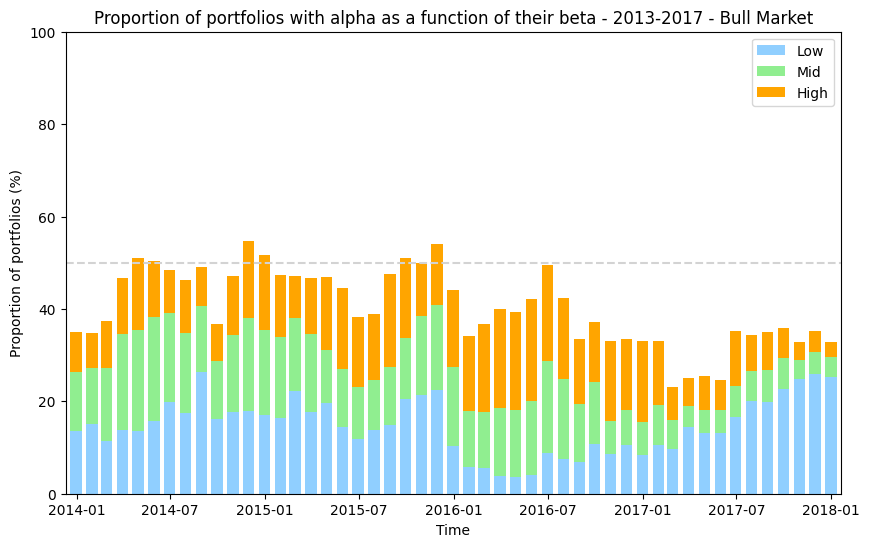

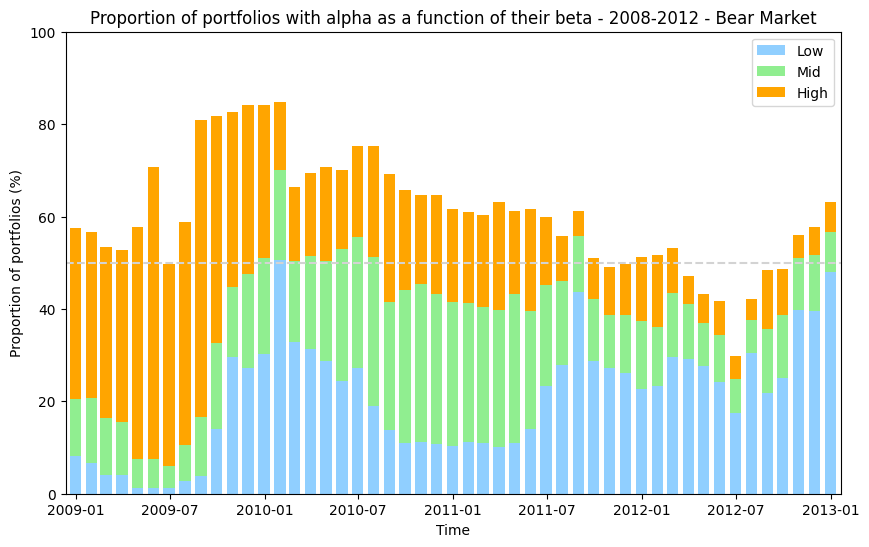

In [38]:
### proporcion de portfolios con alpha segun beta periodos 3 y 4

fig,ax1 = plt.subplots(1,figsize=(10,6))

ax1.bar(alpha5f_bybetas_portfoliosp4.index,height=alpha5f_bybetas_portfoliosp4["low"]/100,width=22,color="#90cfff",label="Low");
ax1.bar(alpha5f_bybetas_portfoliosp4.index,height=alpha5f_bybetas_portfoliosp4["mid"]/100,width=22,color="lightgreen",bottom=alpha5f_bybetas_portfoliosp4["low"]/100,label="Mid");
ax1.bar(alpha5f_bybetas_portfoliosp4.index,height=alpha5f_bybetas_portfoliosp4["high"]/100,width=22,color="orange",
        bottom=alpha5f_bybetas_portfoliosp4["low"]/100 + alpha5f_bybetas_portfoliosp4["mid"]/100,label="High");
#ax1.plot(perfm_carteras,label="Random portfolios");
plt.title("Proportion of portfolios with alpha as a function of their beta - 2013-2017 - Bull Market");
plt.legend()
ax1.set_ylabel("Proportion of portfolios (%)")
ax1.set_xlabel("Time") 
ax1.set_xlim(16050,17550)
ax1.set_ylim(0,100)
ax1.axhline(y=50,color="lightgrey",linestyle="--")
ax1.get_xlim()

plt.savefig("Graphs/Proportion_portfolios_alpha_by_beta_carteras_p4.png")


fig,ax1 = plt.subplots(1,figsize=(10,6))

ax1.bar(alpha5f_bybetas_portfoliosp3.index,height=alpha5f_bybetas_portfoliosp3["low"]/100,width=22,color="#90cfff",label="Low");
ax1.bar(alpha5f_bybetas_portfoliosp3.index,height=alpha5f_bybetas_portfoliosp3["mid"]/100,width=22,color="lightgreen",bottom=alpha5f_bybetas_portfoliosp3["low"]/100,label="Mid");
ax1.bar(alpha5f_bybetas_portfoliosp3.index,height=alpha5f_bybetas_portfoliosp3["high"]/100,width=22,color="orange",
        bottom=alpha5f_bybetas_portfoliosp3["low"]/100 + alpha5f_bybetas_portfoliosp3["mid"]/100,label="High");
#ax1.plot(perfm_carteras,label="Random portfolios");
plt.title("Proportion of portfolios with alpha as a function of their beta - 2008-2012 - Bear Market");
plt.legend()
ax1.set_ylabel("Proportion of portfolios (%)")
ax1.set_xlabel("Time") 
ax1.set_xlim(14225,15725)
ax1.set_ylim(0,100)
ax1.axhline(y=50,color="lightgrey",linestyle="--")
ax1.get_xlim()

plt.savefig("Graphs/Proportion_portfolios_alpha_by_beta_carteras_p3.png")

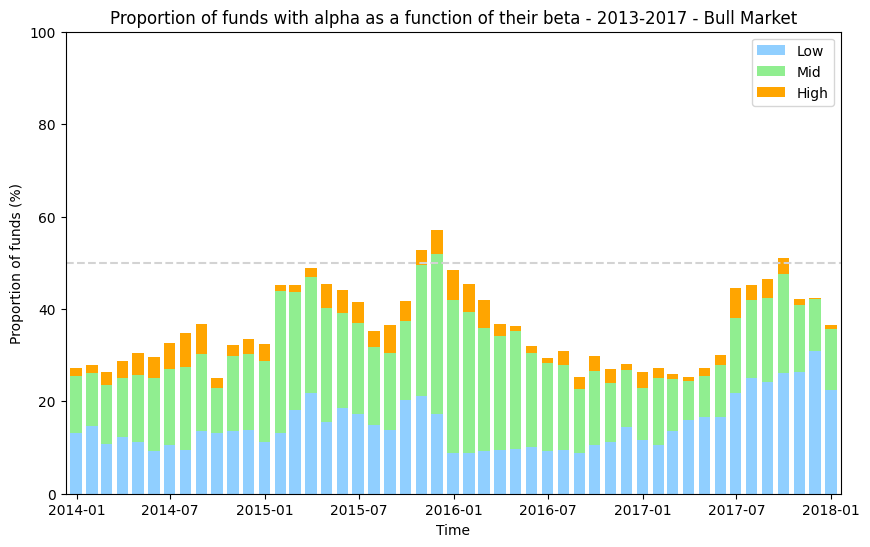

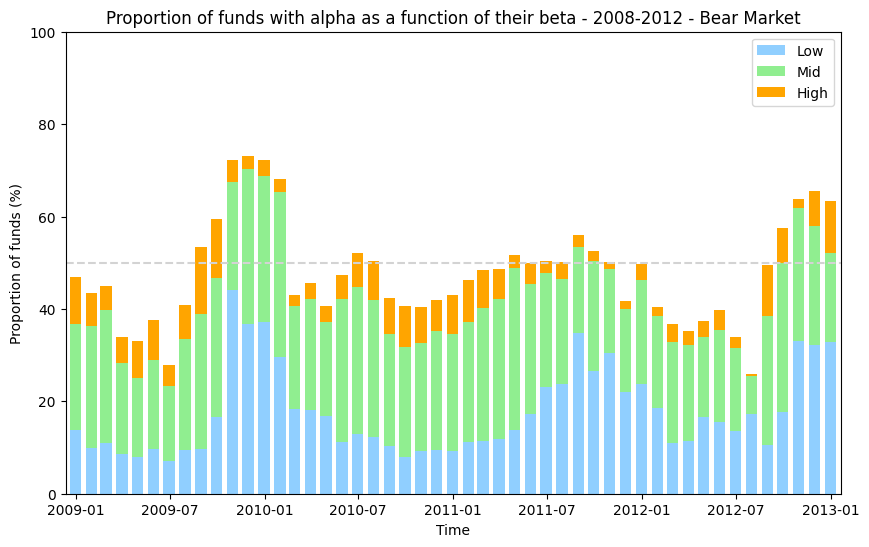

In [40]:
fig,ax1 = plt.subplots(1,figsize=(10,6))

ax1.bar(alpha5f_bybetas_fundsp4.index,height=alpha5f_bybetas_fundsp4["low"]/497*100,width=22,color="#90cfff",label="Low");
ax1.bar(alpha5f_bybetas_fundsp4.index,height=alpha5f_bybetas_fundsp4["mid"]/497*100,width=22,color="lightgreen",bottom=alpha5f_bybetas_fundsp4["low"]/497*100,label="Mid");
ax1.bar(alpha5f_bybetas_fundsp4.index,height=alpha5f_bybetas_fundsp4["high"]/497*100,width=22,color="orange",
        bottom=alpha5f_bybetas_fundsp4["low"]/497*100 + alpha5f_bybetas_fundsp4["mid"]/497*100,label="High");

plt.title("Proportion of funds with alpha as a function of their beta - 2013-2017 - Bull Market");
plt.legend()
ax1.set_ylabel("Proportion of funds (%)")
ax1.set_xlabel("Time") 
ax1.set_xlim(16050,17550)
ax1.set_ylim(0,100)
ax1.axhline(y=50,color="lightgrey",linestyle="--")
ax1.get_xlim()

plt.savefig("Graphs/Proportion_funds_alpha_by_beta_fondos_p4.png")


fig,ax1 = plt.subplots(1,figsize=(10,6))

ax1.bar(alpha5f_bybetas_fundsp3.index,height=alpha5f_bybetas_fundsp3["low"]/430*100,width=22,color="#90cfff",label="Low");
ax1.bar(alpha5f_bybetas_fundsp3.index,height=alpha5f_bybetas_fundsp3["mid"]/430*100,width=22,color="lightgreen",bottom=alpha5f_bybetas_fundsp3["low"]/430*100,label="Mid");
ax1.bar(alpha5f_bybetas_fundsp3.index,height=alpha5f_bybetas_fundsp3["high"]/430*100,width=22,color="orange",
        bottom=alpha5f_bybetas_fundsp3["low"]/430*100 + alpha5f_bybetas_fundsp3["mid"]/430*100,label="High");

plt.title("Proportion of funds with alpha as a function of their beta - 2008-2012 - Bear Market");
plt.legend()
ax1.set_ylabel("Proportion of funds (%)")
ax1.set_xlabel("Time") 
ax1.set_xlim(14225,15725)
ax1.set_ylim(0,100)
ax1.axhline(y=50,color="lightgrey",linestyle="--")
ax1.get_xlim()

plt.savefig("Graphs/Proportion_funds_alpha_by_beta_fondos_p3.png")

In [41]:
def filter_positive_values_first_row(dataframe,column): 
    return (dataframe.iloc[column][dataframe.iloc[column] >0]).index.to_list()
    

def filter_list_components(lista1,lista2):
    return list(set(lista1).intersection(lista2))


def alpha_decay(dataframe,months):

    selection = dataframe

    number_months = months
    number_periods = len(selection.dropna())-number_months

    dataframe_number = pd.DataFrame(columns=range(1,number_periods),index=range(0,number_months))


    for period in range(1,number_periods):

        selection_ = selection.dropna().iloc[period:,]

        temp_list_0 = filter_positive_values_first_row(selection_.dropna(),0)    

        temp_list_1 = filter_list_components(temp_list_0,selection_.dropna().iloc[1][selection_.dropna().iloc[1] >0].index.to_list())

        temp_list_filtered = temp_list_1

        lista_numbers = [len(temp_list_0)]

        for month in range(1,(number_months)):
            
            temp_list_filtered = filter_list_components(temp_list_filtered, selection_.dropna().iloc[month][selection_.dropna().iloc[month] >0].index.to_list())

            lista_numbers.append(len(temp_list_filtered))

        dataframe_number[period] = lista_numbers

    return dataframe_number

In [43]:
alpha_decayf3 = alpha_decay(alpha5f_fundsp3,24)
alpha_decayf4 = alpha_decay(alpha5f_fundsp4,24)

alpha_decayp3 = alpha_decay(alpha5f_portfoliosp3,24)
alpha_decayp4 = alpha_decay(alpha5f_portfoliosp4,24)

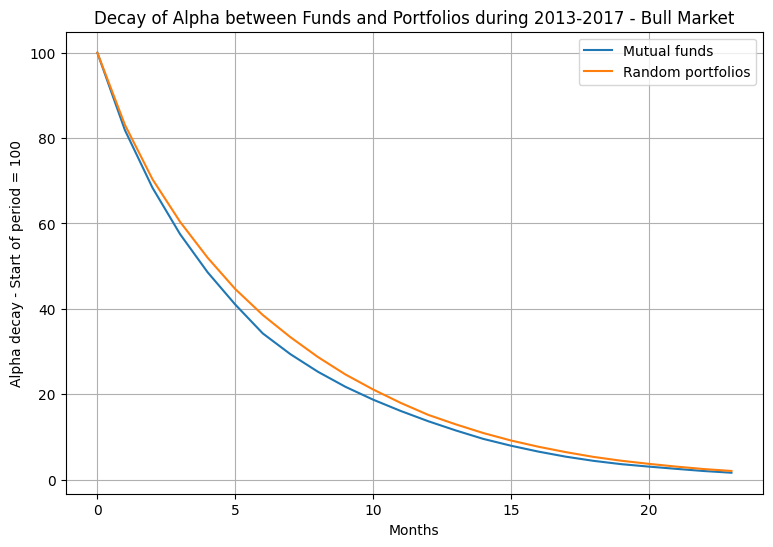

In [44]:
######## plot decay alpha

fig,ax1 = plt.subplots(1,figsize=(9,6))

ax1.plot((alpha_decayf4.mean(axis=1)/alpha_decayf4.mean(axis=1).iloc[0])*100,label="Mutual funds");
ax1.plot((alpha_decayp4.mean(axis=1)/alpha_decayp4.mean(axis=1).iloc[0])*100,label="Random portfolios");
ax1.set_title("Decay of Alpha between Funds and Portfolios during 2013-2017 - Bull Market");
ax1.set_xlabel("Months");
ax1.set_ylabel("Alpha decay - Start of period = 100");
plt.grid(True);
ax1.legend();

plt.savefig("Graphs/alpha_decay_bull.png",dpi=300);

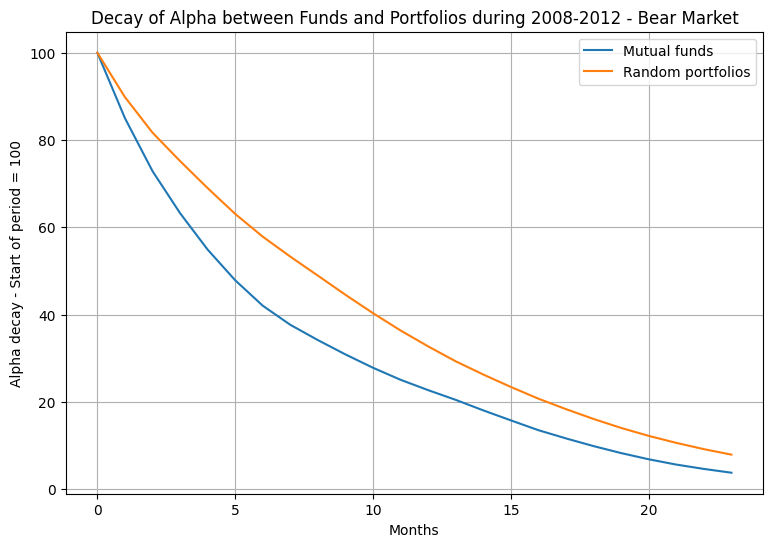

In [45]:
######## plot decay alpha

fig,ax1 = plt.subplots(1,figsize=(9,6))

ax1.plot((alpha_decayf3.mean(axis=1)/alpha_decayf3.mean(axis=1).iloc[0])*100,label="Mutual funds");
ax1.plot((alpha_decayp3.mean(axis=1)/alpha_decayp3.mean(axis=1).iloc[0])*100,label="Random portfolios");
ax1.set_title("Decay of Alpha between Funds and Portfolios during 2008-2012 - Bear Market");
ax1.set_xlabel("Months");
ax1.set_ylabel("Alpha decay - Start of period = 100");
plt.grid(True);
ax1.legend();

plt.savefig("Graphs/alpha_decay_bear.png",dpi=300);

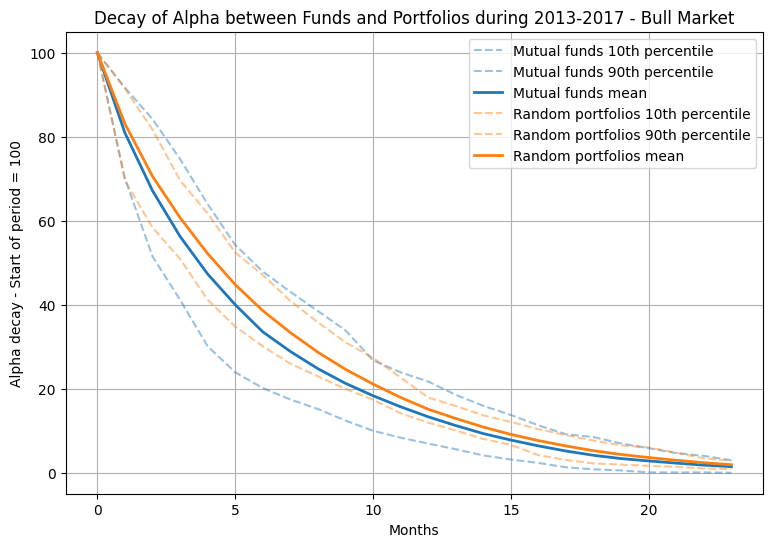

In [46]:
######## plot decay alpha

fig,ax1 = plt.subplots(1,figsize=(9,6))

ax1.plot((alpha_decayf4/alpha_decayf4.iloc[0]).quantile(0.1,axis=1)*100,label="Mutual funds 10th percentile",color="#1f77ba",alpha=0.45,linestyle="dashed");
ax1.plot((alpha_decayf4/alpha_decayf4.iloc[0]).quantile(0.9,axis=1)*100,label="Mutual funds 90th percentile",color="#1f77ba",alpha=0.45,linestyle="dashed");
ax1.plot((alpha_decayf4/alpha_decayf4.iloc[0]).mean(axis=1)*100,label="Mutual funds mean",color="#1f77ba",alpha=1,linewidth=2);

ax1.plot((alpha_decayp4/alpha_decayp4.iloc[0]).quantile(0.1,axis=1)*100,label="Random portfolios 10th percentile",color="#ff7f0e",alpha=0.45,linestyle="dashed");
ax1.plot((alpha_decayp4/alpha_decayp4.iloc[0]).quantile(0.9,axis=1)*100,label="Random portfolios 90th percentile",color="#ff7f0e",alpha=0.45,linestyle="dashed");
ax1.plot((alpha_decayp4/alpha_decayp4.iloc[0]).mean(axis=1)*100,label="Random portfolios mean",color="#ff7f0e",alpha=1,linewidth=2);

ax1.set_title("Decay of Alpha between Funds and Portfolios during 2013-2017 - Bull Market");
ax1.set_xlabel("Months");
ax1.set_ylabel("Alpha decay - Start of period = 100");
plt.grid(True);
ax1.legend();

plt.savefig("Graphs/alpha_decay_bull_v2.png",dpi=300);

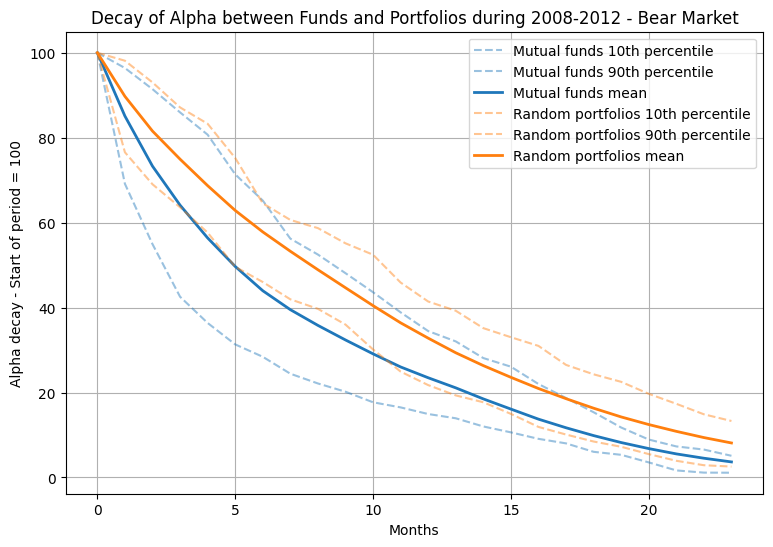

In [47]:
######## plot decay alpha

fig,ax1 = plt.subplots(1,figsize=(9,6))

ax1.plot((alpha_decayf3/alpha_decayf3.iloc[0]).quantile(0.1,axis=1)*100,label="Mutual funds 10th percentile",color="#1f77ba",alpha=0.45,linestyle="dashed");
ax1.plot((alpha_decayf3/alpha_decayf3.iloc[0]).quantile(0.9,axis=1)*100,label="Mutual funds 90th percentile",color="#1f77ba",alpha=0.45,linestyle="dashed");
ax1.plot((alpha_decayf3/alpha_decayf3.iloc[0]).mean(axis=1)*100,label="Mutual funds mean",color="#1f77ba",alpha=1,linewidth=2);

ax1.plot((alpha_decayp3/alpha_decayp3.iloc[0]).quantile(0.1,axis=1)*100,label="Random portfolios 10th percentile",color="#ff7f0e",alpha=0.45,linestyle="dashed");
ax1.plot((alpha_decayp3/alpha_decayp3.iloc[0]).quantile(0.9,axis=1)*100,label="Random portfolios 90th percentile",color="#ff7f0e",alpha=0.45,linestyle="dashed");
ax1.plot((alpha_decayp3/alpha_decayp3.iloc[0]).mean(axis=1)*100,label="Random portfolios mean",color="#ff7f0e",alpha=1,linewidth=2);



ax1.set_title("Decay of Alpha between Funds and Portfolios during 2008-2012 - Bear Market");
ax1.set_xlabel("Months");
ax1.set_ylabel("Alpha decay - Start of period = 100");
plt.grid(True);
ax1.legend();

plt.savefig("Graphs/alpha_decay_bear_v2.png",dpi=300);

In [49]:
label_funds = pd.DataFrame(index=["Label"],columns=factorsfp3.dropna(axis=1).columns,data="Mutual fund")
factorsfp3.dropna(axis=1).append(label_funds)

label_portfolios = pd.DataFrame(index=["Label"],columns=factorsp3[:-2].columns,data="Random Portfolio")
factorsp3.append(label_portfolios)

test_labelled_p3 = factorsfp3.dropna(axis=1).append(label_funds).join(factorsp3.append(label_portfolios))

test_labelled_p3.T.to_csv("Computations/ClassificationP3.csv")


label_funds = pd.DataFrame(index=["Label"],columns=factorsfp4.dropna(axis=1).columns,data="Mutual fund")
factorsfp4.dropna(axis=1).append(label_funds)

label_cartera = pd.DataFrame(index=["Label"],columns=factorsp4[:-2].columns,data="Random Portfolio")
factorsp4.append(label_cartera)

test_labelled_p4 = factorsfp4.dropna(axis=1).append(label_funds).join(factorsp4.append(label_portfolios))

test_labelled_p4.T.to_csv("Computations/ClassificationP4.csv")

In [51]:
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, confusion_matrix
  
target = test_labelled_p3.T["Label"]
features = test_labelled_p3.T.drop(["R2","Label","P-value Alpha"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(features,target, test_size = 0.5, random_state = 668410)
from sklearn.svm import SVC
  
# Building a Support Vector Machine on train data
svc_model = SVC(C= .1, kernel='linear', gamma= 1)
svc_model.fit(X_train, y_train)
  
prediction = svc_model .predict(X_test)
# check the accuracy on the training set
print(svc_model.score(X_train, y_train))
print(svc_model.score(X_test, y_test))

print("Confusion Matrix:\n",confusion_matrix(y_test,prediction))

0.9581975071907958
0.959731543624161
Confusion Matrix:
 [[   2  210]
 [   0 5003]]


In [52]:
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, confusion_matrix
  
target = test_labelled_p4.T["Label"]
features = test_labelled_p4.T.drop(["R2","Label","P-value Alpha"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(features,target, test_size = 0.5, random_state = 668410)
from sklearn.svm import SVC
  
# Building a Support Vector Machine on train data
svc_model = SVC(C= .1, kernel='linear', gamma= 1)
svc_model.fit(X_train, y_train)
  
prediction = svc_model.predict(X_test)
# check the accuracy on the training set
print(svc_model.score(X_train, y_train))
print(svc_model.score(X_test, y_test))

print("Confusion Matrix:\n",confusion_matrix(y_test,prediction))

0.9523628048780488
0.9529434177938655
Confusion Matrix:
 [[   0  247]
 [   0 5002]]


In [59]:
############## k means

from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix
kmeans = KMeans(n_clusters=2)
kmeans.fit(test_labelled_p3.T.drop(["R2","Label","P-value Alpha"], axis=1))


y_kmeans = kmeans.predict(test_labelled_p3.T.drop(["R2","Label","P-value Alpha"], axis=1))

#confusion_matrix()

print(accuracy_score(test_labelled_p3.T["Label"].factorize()[0], y_kmeans))
confusion_matrix(test_labelled_p3.T["Label"].factorize()[0], y_kmeans)


0.5179290508149569


array([[ 407,   23],
       [5005, 4995]], dtype=int64)

In [58]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(test_labelled_p4.T.drop(["R2","Label","P-value Alpha"], axis=1))


y_kmeans = kmeans.predict(test_labelled_p4.T.drop(["R2","Label","P-value Alpha"], axis=1))

#confusion_matrix()

print(accuracy_score(test_labelled_p4.T["Label"].factorize()[0], y_kmeans))
confusion_matrix(test_labelled_p4.T["Label"].factorize()[0], y_kmeans)

0.527102981804325


array([[ 460,   37],
       [4927, 5073]], dtype=int64)